In [73]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

In [74]:
file_path = '/Users/arpit/Documents/DMT_Project/DataSet/2020/heart_2020_cleaned.csv'
data = pd.read_csv(file_path)

In [75]:
data.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [76]:
# Dropping the 'Race' column
data = data.drop('Race', axis=1)

# Displaying the first few records of the modified dataset to confirm the change
(data.head(5))

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,No,Yes,Very good,8.0,No,No,No


In [77]:
# Categorical features are those that are of type 'object'
num_categorical_features = sum(data.dtypes == 'object')

# Printing the number of categorical features
print("Number of categorical features:", num_categorical_features)

Number of categorical features: 13


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Diabetic          319795 non-null  object 
 11  PhysicalActivity  319795 non-null  object 
 12  GenHealth         319795 non-null  object 
 13  SleepTime         319795 non-null  float64
 14  Asthma            319795 non-null  object 
 15  KidneyDisease     319795 non-null  object 
 16  SkinCancer        31

### Data distribution graph of all the categorical features

['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']


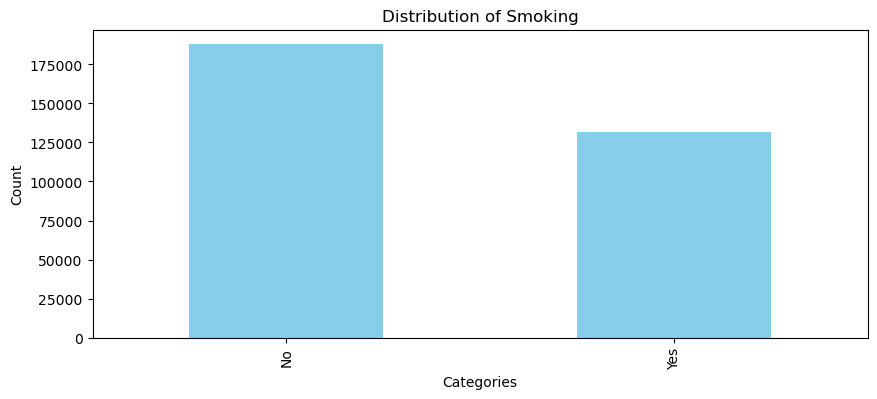

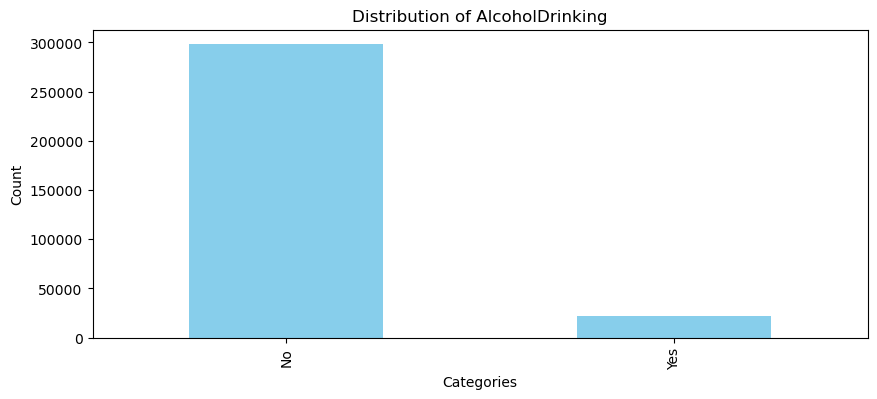

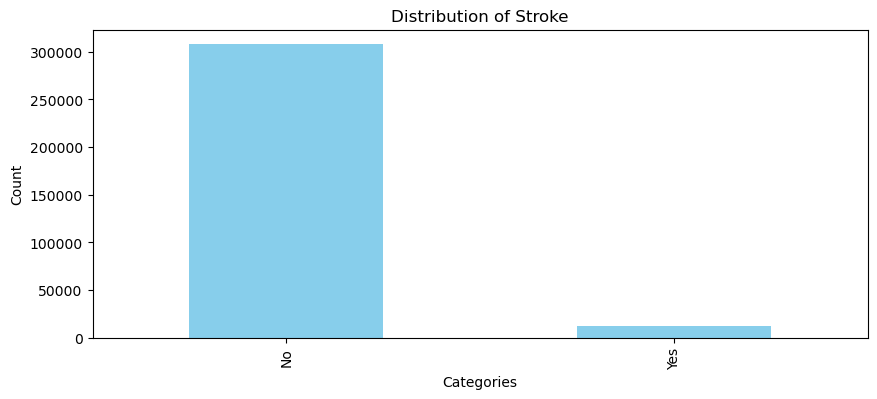

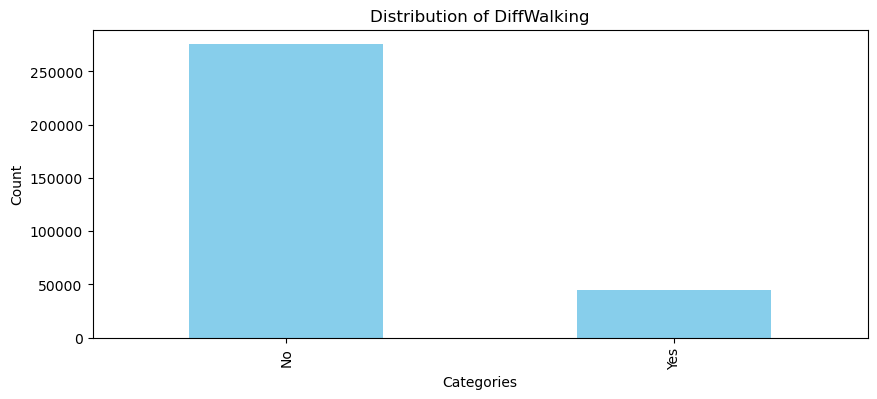

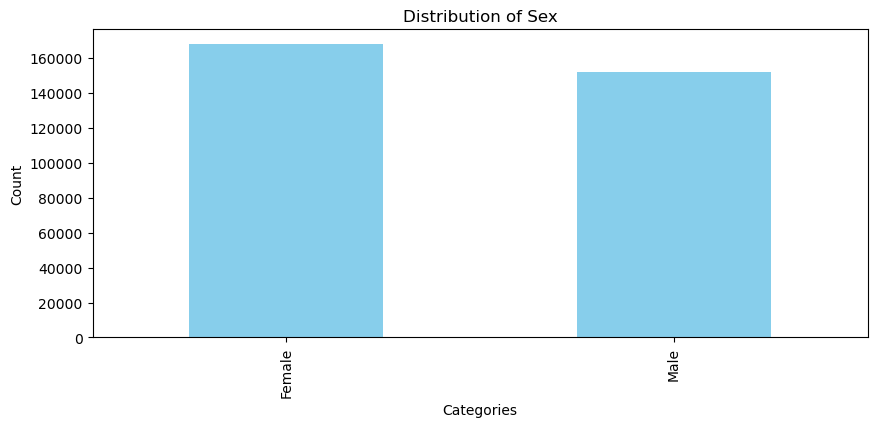

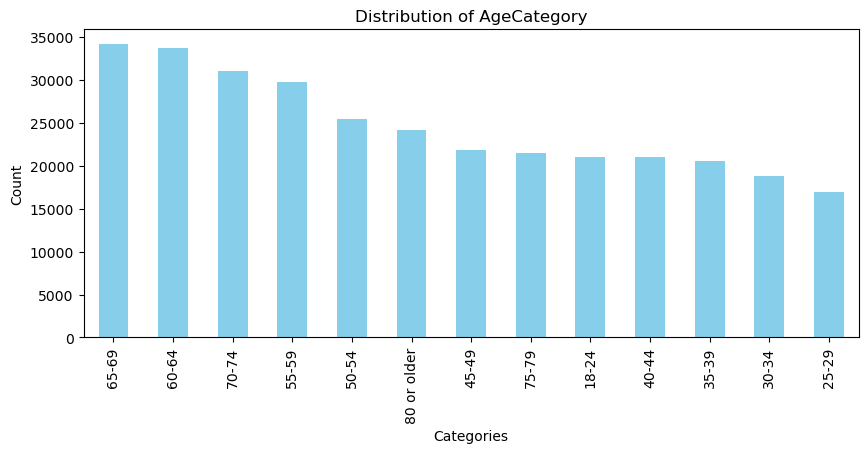

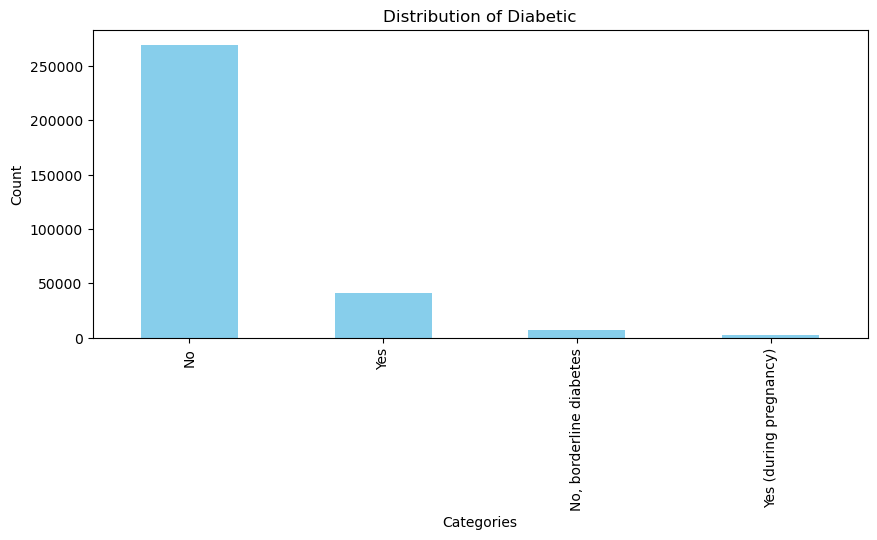

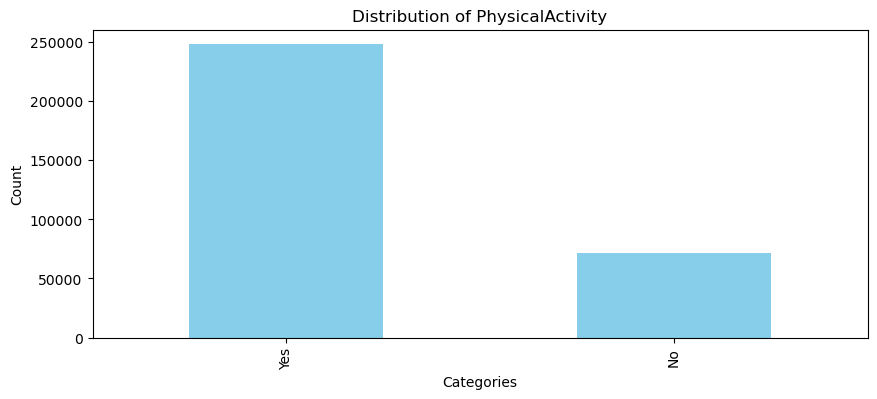

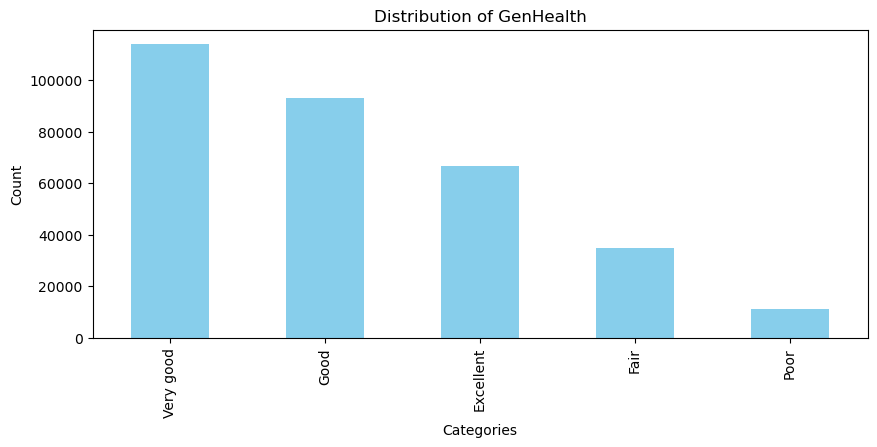

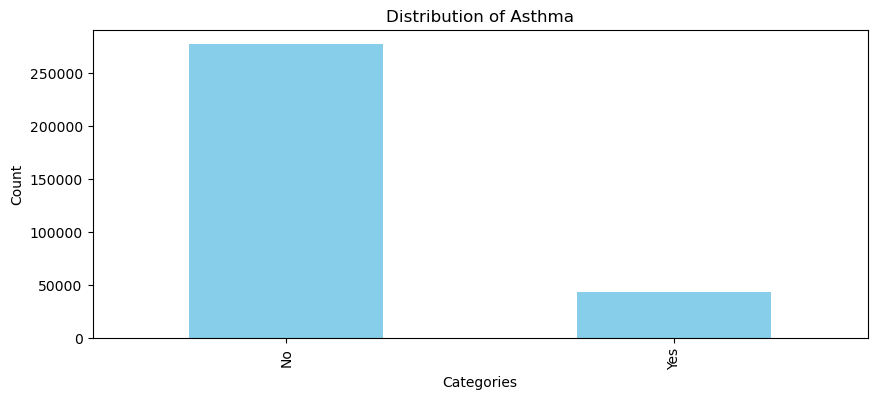

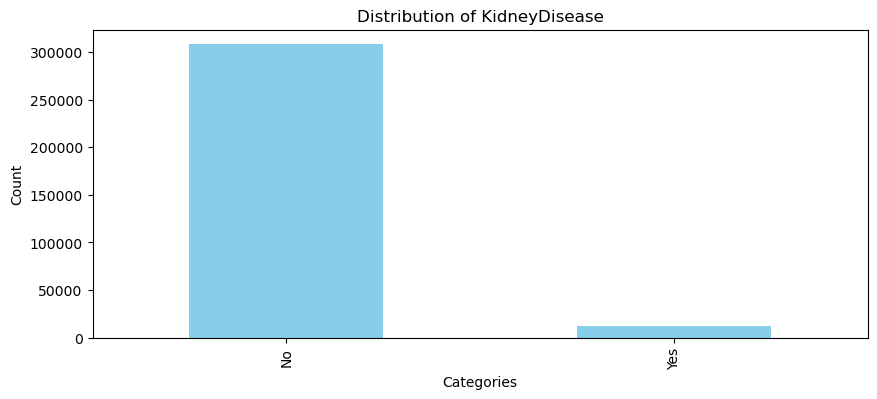

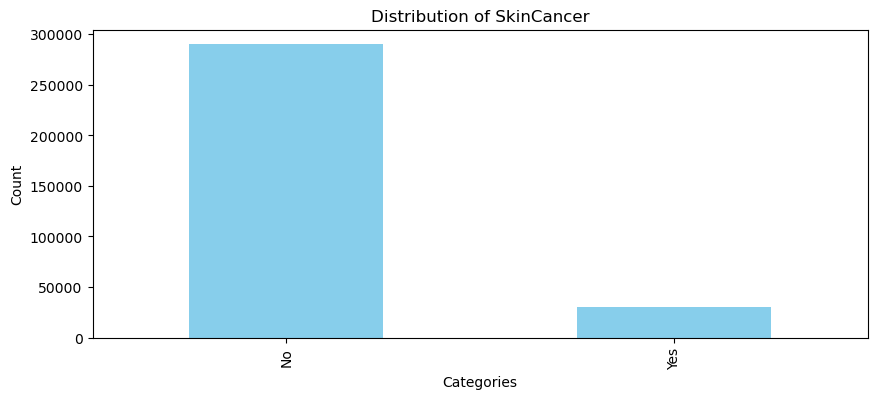

In [79]:
# Identifying original categorical features before encoding
original_categorical_features = [col for col in data.columns if data[col].dtype == 'object']
print(original_categorical_features)

# Removing 'HeartDisease' from the list of categorical features
categorical_features_without_target = [col for col in original_categorical_features if col != 'HeartDisease']

# Plotting the data distribution for each categorical feature (except 'HeartDisease')
for col in categorical_features_without_target:
    plt.figure(figsize=(10, 4))
    data[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xlabel('Categories')
    plt.show()

### Checking if there are any missing values

In [80]:
data.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

## Data Preprocessing

### As we can see above in the dataset, there are many categorical variables (Yes/No). So, first we will be doing label encoding for binary categorical variables and one-hot encoding for multi-categorical variables

In [81]:
# Identify binary and multi-category categorical variables
binary_columns = [col for col in data.columns if data[col].dtype == 'object' and data[col].nunique() == 2]
multi_cat_columns = [col for col in data.columns if data[col].dtype == 'object' and data[col].nunique() > 2]

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding for binary categorical variables
for col in binary_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Apply One-Hot Encoding for multi-category variables
data = pd.get_dummies(data, columns=multi_cat_columns)

In [82]:
data.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,AgeCategory_80 or older,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,0,1,...,False,False,False,True,False,False,False,False,False,True
1,0,20.34,0,0,1,0.0,0.0,0,0,1,...,True,True,False,False,False,False,False,False,False,True
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,False,False,False,True,False,False,True,False,False,False
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,False,True,False,False,False,False,False,True,False,False
4,0,23.71,0,0,0,28.0,0.0,1,0,1,...,False,True,False,False,False,False,False,False,False,True


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   HeartDisease                      319795 non-null  int64  
 1   BMI                               319795 non-null  float64
 2   Smoking                           319795 non-null  int64  
 3   AlcoholDrinking                   319795 non-null  int64  
 4   Stroke                            319795 non-null  int64  
 5   PhysicalHealth                    319795 non-null  float64
 6   MentalHealth                      319795 non-null  float64
 7   DiffWalking                       319795 non-null  int64  
 8   Sex                               319795 non-null  int64  
 9   PhysicalActivity                  319795 non-null  int64  
 10  SleepTime                         319795 non-null  float64
 11  Asthma                            319795 non-null  i

In [84]:
# Convert True/False to 1/0 for all columns
for col in data.columns:
    if data[col].dtype == 'bool':
        data[col] = data[col].astype(int)

data.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,AgeCategory_80 or older,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,0,1,...,0,1,0,0,0,0,0,0,0,1


### Plotting a bar graph for the distribution of the 'HeartDisease' target variable

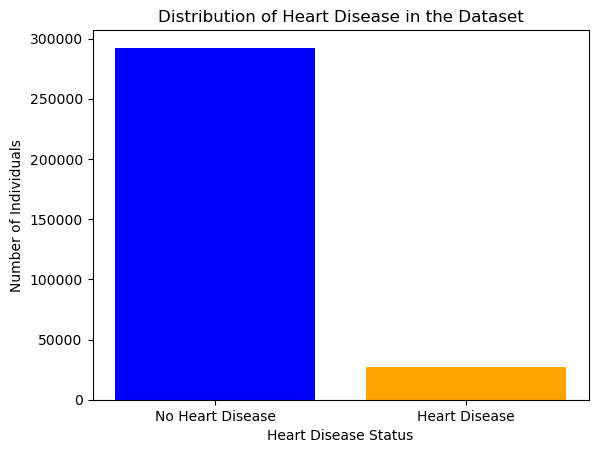

In [85]:

heart_disease_counts = data['HeartDisease'].value_counts()

plt.bar(heart_disease_counts.index, heart_disease_counts.values, color=['blue', 'orange'])
plt.xlabel('Heart Disease Status')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Heart Disease in the Dataset')
plt.xticks([0, 1], ['No Heart Disease', 'Heart Disease'])
plt.show()

In [86]:
data.head(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,AgeCategory_80 or older,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,0,1,...,0,1,0,0,0,0,0,0,0,1


In [87]:
# Separating features and target variable
X = data.drop('HeartDisease', axis=1)  # Features
y = data['HeartDisease']               # Target variable

### In my case, 'HeartDisease' feature is disproportionately distributed between different classes (e.g., more instances of 'No' than 'Yes' for heart disease). As the data is imbalanced, so I am using SMOTE_ENN to oversample the minority class in the training set. SMOTE_ENN is used to create synthetic samples rather than just duplicating existing ones

In [88]:
# Apply SMOTE-ENN for over-sampling and cleaning
smote_enn = SMOTE(k_neighbors = 40, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

### The 'BMI', 'PhysicalHealth', 'MentalHealth', and 'SleepTime' variables are numerical features and require scaling. Standardization has been applied to ensure these features contribute equally to the model's performance.

In [89]:
# Apply StandardScaler to the resampled data
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

### Splitting the dataset into training set of 80% and testing set of 20%

In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

### Model Training and evaluation

In [91]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter = 1000, C = 0.1)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Predict on the training set and the testing set
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluate the model on the training set
train_classification_report = classification_report(y_train, y_train_pred)
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on the testing set
test_classification_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

### Checking for any overfitting

In [92]:
print("Training Accuracy:", round(train_accuracy, 2))
print("Testing Accuracy:", round(test_accuracy, 2))

Training Accuracy: 0.87
Testing Accuracy: 0.88


As we can see above that both the training and testing accuracy are almost close to each other. So, we can say that there is no overfitting

### Testing classification report

In [93]:
print("\nTesting Classification Report:\n", test_classification_report)
print("Testing Confusion Matrix:\n", test_confusion_matrix)


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88     58485
           1       0.91      0.83      0.87     58484

    accuracy                           0.88    116969
   macro avg       0.88      0.88      0.87    116969
weighted avg       0.88      0.88      0.87    116969

Testing Confusion Matrix:
 [[53689  4796]
 [ 9809 48675]]


1. The model has a precision of 0.85 for the majority class (class 0) and a very high precision of 0.91 for the minority class (class 1). This means that when the model predicts heart disease (class 1), it is correct 91% of the time, which is excellent.

2. Recall: The recall for the majority class is 0.92, which is quite high, indicating the model is able to capture most of the true negatives. The recall for the minority class is 0.83, which means the model is identifying 83% of all true positive cases.

3. F1-Score: The F1-score, which is a harmonic mean of precision and recall, is 0.88 for the majority class and 0.87 for the minority class. These scores are very close, suggesting a balanced performance between precision and recall for both classes.

### Plotting Confusion Matrix

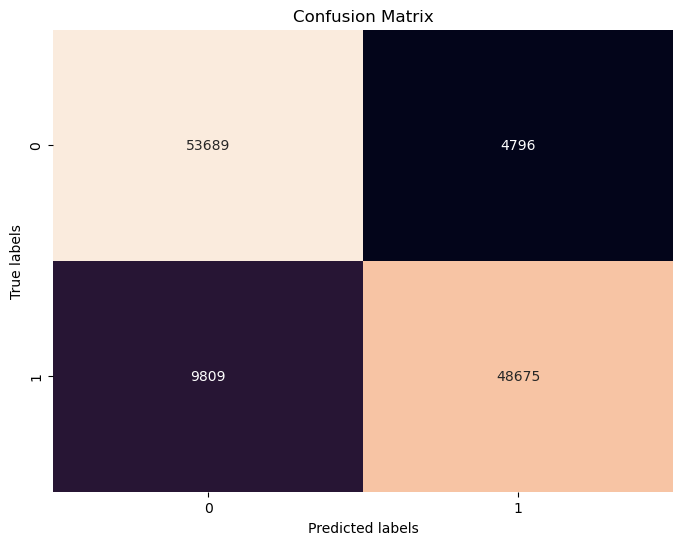

In [94]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that the model has more false positives (5318) than false negatives (9504) for the majority class, while for the minority class, the number of true positives (48980) is significantly higher than false negatives (9504), reinforcing the high recall.

In [95]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Calculate the precision
precision = precision_score(y_test, y_test_pred)

# Calculate the recall
recall = recall_score(y_test, y_test_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_test_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.88
Precision: 0.91
Recall: 0.83
F1 Score: 0.87


Overall Accuracy: The model has an overall accuracy of 87% on the testing set, which is quite high and suggests good generalization from the training data.

### Plotting ROC curve for predicting heart disease

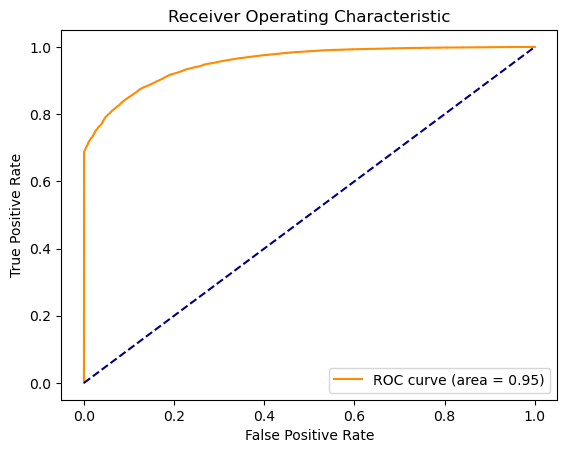

In [97]:
# Calculate the predicted probabilities for the test set
y_test_probs = log_reg.predict_proba(X_test)[:, 1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The AUC is 0.95, which is quite high. This means that the model has a high degree of separability, indicating that it is very capable of distinguishing between the two classes (presence and absence of heart disease).

## Evaluation metrics without using SMOTE

In [98]:
# Apply StandardScaler to the resampled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [100]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter = 1000, C = 0.1)

# Train the model on the training set
log_reg.fit(X_train, y_train)

# Predict on the training set and the testing set
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluate the model on the training set
train_classification_report = classification_report(y_train, y_train_pred)
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate the model on the testing set
test_classification_report = classification_report(y_test, y_test_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

### Testing Classification report

In [101]:
print("\nTesting Classification Report:\n", test_classification_report)
print("Testing Confusion Matrix:\n", test_confusion_matrix)


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.17      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.91      0.89     63959

Testing Confusion Matrix:
 [[57890   477]
 [ 5036   556]]


### Plotting Confusion Matrix

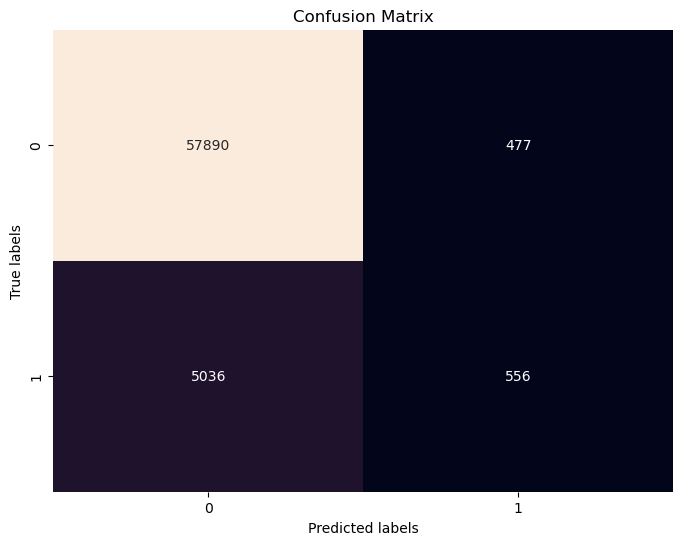

In [102]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Calculation of precision, recall, f1-score and accuracy

In [103]:
# Calcualte precision score
precision_ns = precision_score(y_test, y_test_pred)
# Calculate accuracy
accuracy_ns = accuracy_score(y_test, y_test_pred)
# Calculate recall score
recall_ns = recall_score(y_test, y_test_pred)
# Calculate the F1 score
f1_score_ns = f1_score(y_test, y_test_pred)

In [104]:
print(f'Precision: {precision_ns:.2f}')
print(f'Recall: {recall_ns:.2f}')
print(f'F1 Score: {f1_score_ns:.2f}')
print(f'Accuracy: {accuracy_ns:.2f}')

Precision: 0.54
Recall: 0.10
F1 Score: 0.17
Accuracy: 0.91


## Plotting bar graph for comparison of evaluation metrics with SMOTE and without SMOTE

In [107]:
ns_scores = [precision_ns, recall_ns, f1_score_ns, accuracy_ns]
s_scores = [precision, recall, f1, accuracy]

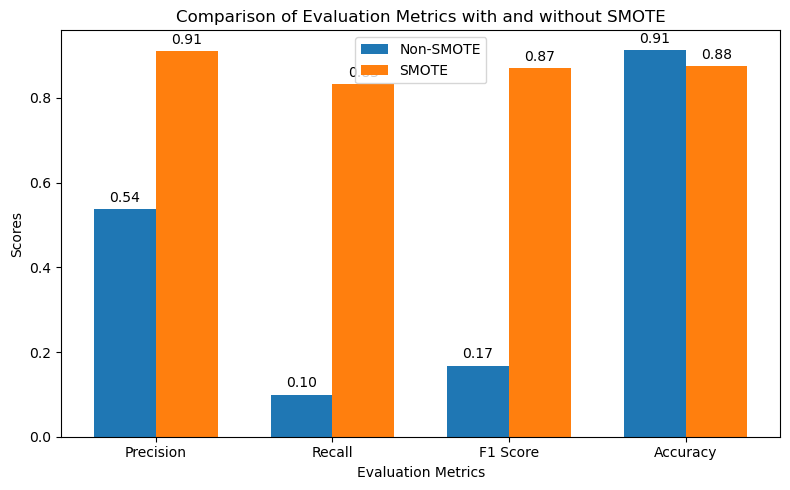

In [112]:
# Define the labels for the bars
labels = ['Precision', 'Recall', 'F1 Score', 'Accuracy']

# Define the x position of groups
x = np.arange(len(labels))

# Define bar width
bar_width = 0.35

# Create the figure and an axes
fig, ax = plt.subplots()

# Set figure size
fig.set_size_inches(8, 5)

# Plot bars for each set of scores
rects1 = ax.bar(x - bar_width/2, ns_scores, bar_width, label='Non-SMOTE')
rects2 = ax.bar(x + bar_width/2, s_scores, bar_width, label='SMOTE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics with and without SMOTE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Show the plot
plt.tight_layout()
plt.show()

Based on the bar graph in the picture, which compares the evaluation metrics with and without using SMOTE (Synthetic Minority Over-sampling Technique), we can infer the following:

1. Precision: Precision is higher with SMOTE compared to without SMOTE. This indicates that when using SMOTE, the model is better at returning relevant results; that is, when it predicts the positive class, it is correct more often.

2. Recall: Recall is significantly higher with SMOTE. This suggests that after applying SMOTE, the model is better at identifying all relevant cases within the positive class. Essentially, it misses fewer positive cases.

3. F1 Score: The F1 Score, which is the harmonic mean of precision and recall, is also higher with SMOTE. This indicates a better balance between precision and recall when using SMOTE, leading to a more effective model overall for the positive class.

4. Accuracy: Accuracy appears to be the same with and without SMOTE. This could mean that the overall number of correct predictions over the total number of cases remains unchanged, regardless of the balance between the classes.